# Projet diab-ethique


# Import des library


In [159]:
import os
import numpy as np
import pandas as pd
import functools as ft
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# Chargement des données en mémoire

In [133]:
GENERAL_DATA_PATH = os.path.join("Datasets", "general_data")
MANAGER_SURVEY_DATA_PATH = os.path.join("Datasets", "manager_survey_data")
EMPLOYEE_SURVEY_DATA_PATH = os.path.join("Datasets", "employee_survey_data",)

def load_general_data(general_path=GENERAL_DATA_PATH):
    csv_path = os.path.join(general_path, "general_data.csv")
    return pd.read_csv(csv_path)

def load_manager_survey_data(manager_survey_data=MANAGER_SURVEY_DATA_PATH):
    csv_path = os.path.join(manager_survey_data, "manager_survey_data.csv")
    return pd.read_csv(csv_path)

def load_employee_survey_data(employee_survey_data=EMPLOYEE_SURVEY_DATA_PATH):
    csv_path = os.path.join(employee_survey_data, "employee_survey_data.csv")
    return pd.read_csv(csv_path)

general = load_general_data()
manager_survey = load_manager_survey_data()
employee_survey = load_employee_survey_data()

### Rassemblement des plusieurs tables en une seul


In [134]:
#ici faire le merge de toutes les tables
multiArray = [general, manager_survey, employee_survey]
data = ft.reduce(lambda left, right: pd.merge(left,right,on='EmployeeID'), multiArray)

### Visualisation des données

In [135]:
#Faire le .head et .info
data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


## Cohérence des données

In [136]:
dtypes = pd.DataFrame(data.dtypes, columns=['Type'])
dtypes['Null'] = data.isnull().sum()
dtypes['N-Unique'] = data.nunique()
dtypes['Unique'] = [data[col].unique() if data[col].dtype == 'object' else [] for col in data.columns]
dtypes.head()
dtypes

,Type,Null,N-Unique,Unique
Age,int64,0,43,[]
Attrition,object,0,2,"[No, Yes]"
BusinessTravel,object,0,3,"[Travel_Rarely, Travel_Frequently, Non-Travel]"
Department,object,0,3,"[Sales, Research & Development, Human Resources]"
DistanceFromHome,int64,0,29,[]
Education,int64,0,5,[]
EducationField,object,0,6,"[Life Sciences, Other, Medical, Marketing, Tec..."
EmployeeCount,int64,0,1,[]
EmployeeID,int64,0,4410,[]
Gender,object,0,2,"[Female, Male]"


In [137]:
#import seaborn as sns
#fig = plt.figure(figsize=(30,34))
#for idx,i in enumerate(data.columns.tolist()):
#    ax=plt.subplot(8,4,idx+1)
#    sns.countplot(x=i,data=data,ax=ax)
#plt.show()

# Suppresion des données (j'ai les datas) jugées non-éthiques


In [138]:
del data['Gender']
del data['Age']
del data['Over18']
del data['MaritalStatus']
del data['StandardHours']
del data['EmployeeCount']
del data['EmployeeID']

In [139]:
data.head()

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,131160,1.0,...,1.0,6,1,0,0,3,3,3.0,4.0,2.0
1,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,41890,0.0,...,6.0,3,5,1,4,2,4,3.0,2.0,4.0
2,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,193280,1.0,...,5.0,2,5,0,3,3,3,2.0,2.0,1.0
3,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,83210,3.0,...,13.0,5,8,7,5,2,3,4.0,4.0,3.0
4,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,23420,4.0,...,9.0,2,6,0,4,3,3,4.0,1.0,3.0


justification ethique et pas ethique 


In [140]:
convert_collumns = {
    'BusinessTravel': 'category',
    'Department': 'category',
    'EducationField': 'category',
    'JobRole': 'category'
}

data = data.astype(convert_collumns)
data_num = data.select_dtypes(include=[np.number])
data['Attrition'] = data['Attrition'].replace(['Yes','No'],[1,0])


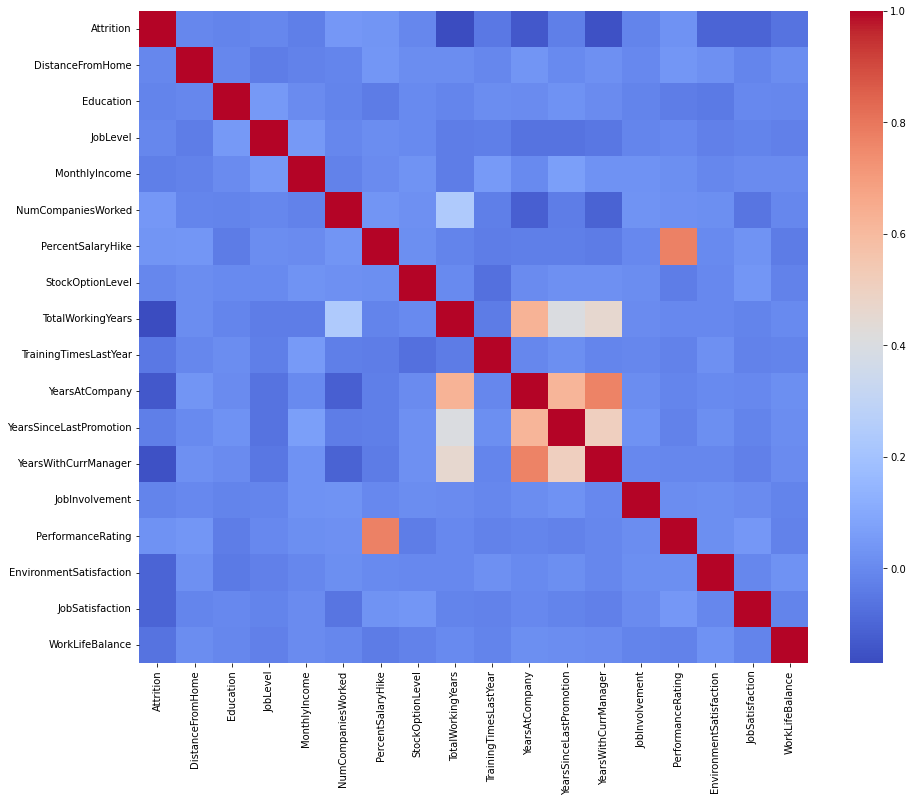

In [144]:
correlation = data.corr()
fig = plt.gcf()
fig.set_size_inches(15,12)
sns.heatmap(correlation,cmap='coolwarm')
plt.show()

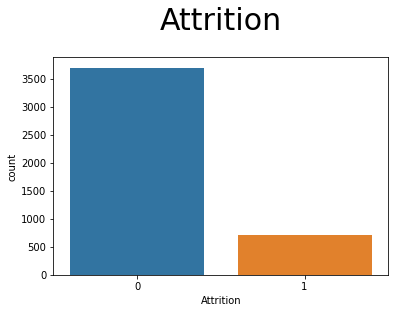

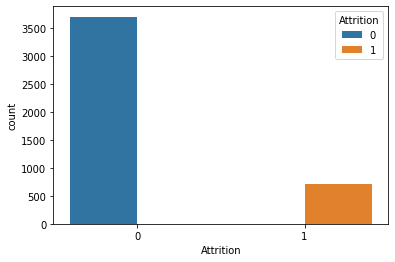

Attrition         0         1
Attrition                    
0          1.000000  0.000000
1          0.000000  1.000000
All        0.838776  0.161224





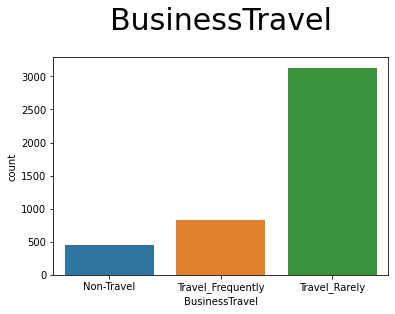

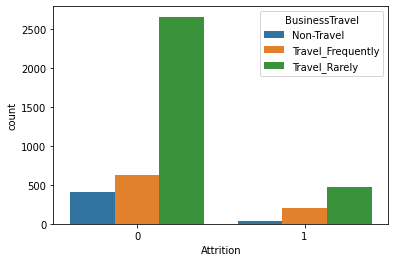

Attrition                 0         1
BusinessTravel                       
Non-Travel         0.920000  0.080000
Travel_Frequently  0.750903  0.249097
Travel_Rarely      0.850431  0.149569
All                0.838776  0.161224





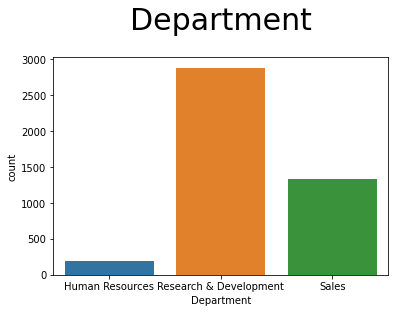

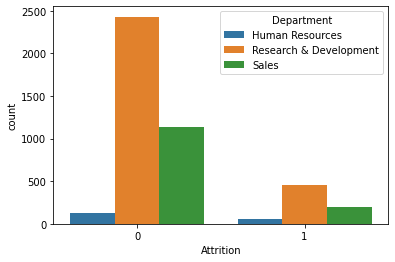

Attrition                      0         1
Department                                
Human Resources         0.698413  0.301587
Research & Development  0.842872  0.157128
Sales                   0.849776  0.150224
All                     0.838776  0.161224





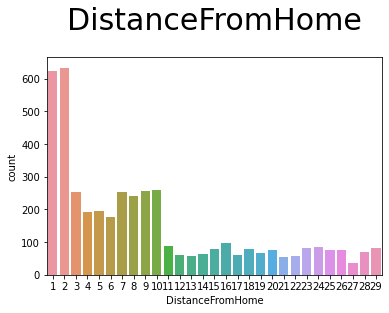

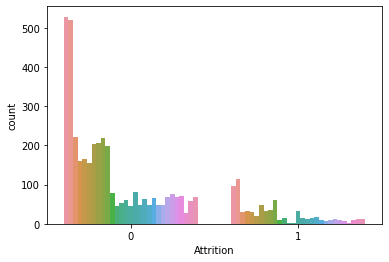

Attrition                0         1
DistanceFromHome                    
1                 0.846154  0.153846
2                 0.819905  0.180095
3                 0.880952  0.119048
4                 0.828125  0.171875
5                 0.846154  0.153846
6                 0.881356  0.118644
7                 0.809524  0.190476
8                 0.862500  0.137500
9                 0.858824  0.141176
10                0.767442  0.232558
11                0.896552  0.103448
12                0.750000  0.250000
13                0.947368  0.052632
14                0.952381  0.047619
15                0.576923  0.423077
16                0.843750  0.156250
17                0.800000  0.200000
18                0.807692  0.192308
19                0.727273  0.272727
20                0.880000  0.120000
21                0.888889  0.111111
22                0.842105  0.157895
23                0.851852  0.148148
24                0.892857  0.107143
25                0.920000  0.080000
2

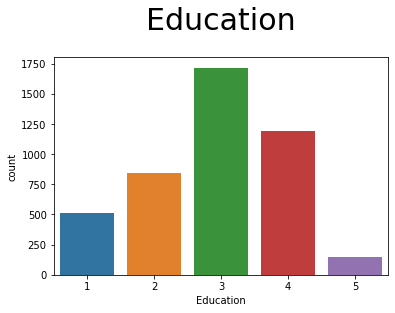

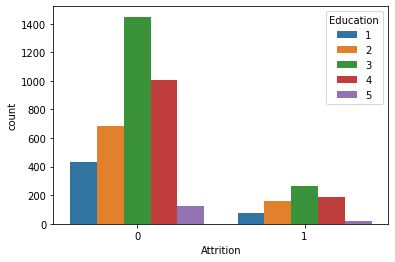

Attrition         0         1
Education                    
1          0.847059  0.152941
2          0.812057  0.187943
3          0.844406  0.155594
4          0.844221  0.155779
5          0.854167  0.145833
All        0.838776  0.161224





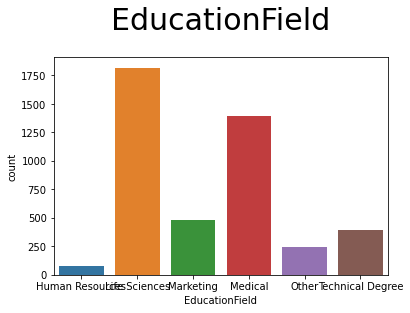

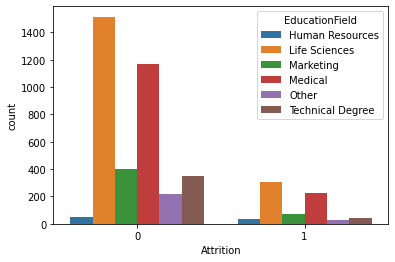

Attrition                0         1
EducationField                      
Human Resources   0.592593  0.407407
Life Sciences     0.833333  0.166667
Marketing         0.842767  0.157233
Medical           0.838362  0.161638
Other             0.878049  0.121951
Technical Degree  0.886364  0.113636
All               0.838776  0.161224





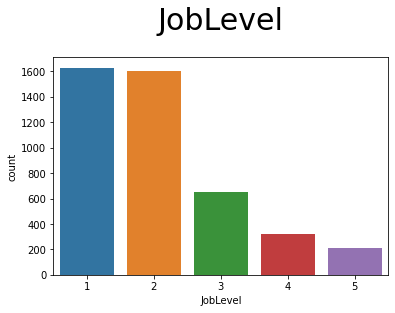

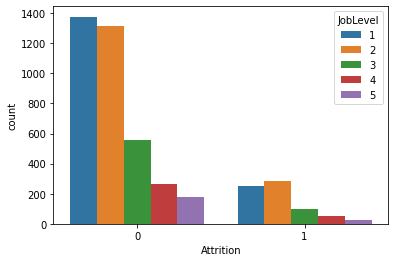

Attrition         0         1
JobLevel                     
1          0.845304  0.154696
2          0.822097  0.177903
3          0.853211  0.146789
4          0.839623  0.160377
5          0.869565  0.130435
All        0.838776  0.161224





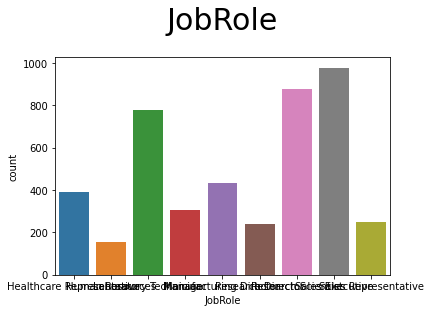

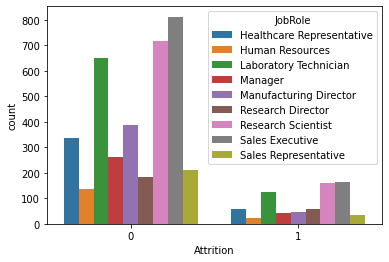

Attrition                         0         1
JobRole                                      
Healthcare Representative  0.854962  0.145038
Human Resources            0.865385  0.134615
Laboratory Technician      0.837838  0.162162
Manager                    0.862745  0.137255
Manufacturing Director     0.889655  0.110345
Research Director          0.762500  0.237500
Research Scientist         0.818493  0.181507
Sales Executive            0.831288  0.168712
Sales Representative       0.855422  0.144578
All                        0.838776  0.161224





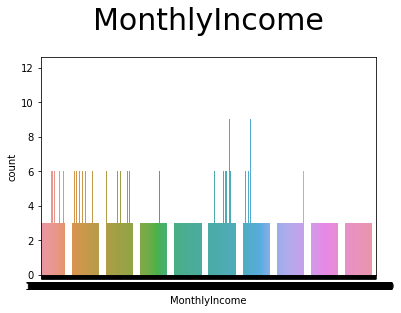

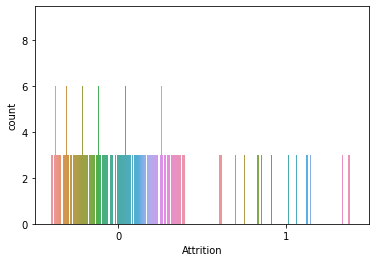

Attrition             0         1
MonthlyIncome                    
10090          0.000000  1.000000
10510          1.000000  0.000000
10520          1.000000  0.000000
10810          1.000000  0.000000
10910          1.000000  0.000000
...                 ...       ...
199260         1.000000  0.000000
199430         1.000000  0.000000
199730         1.000000  0.000000
199990         1.000000  0.000000
All            0.838776  0.161224

[1350 rows x 2 columns]





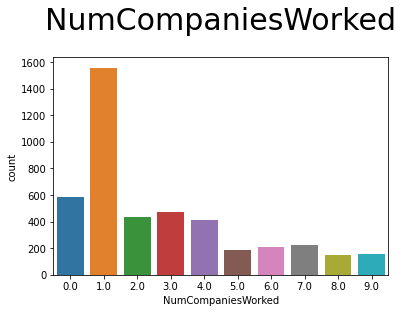

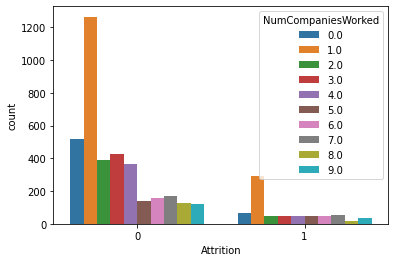

Attrition                  0         1
NumCompaniesWorked                    
0.0                 0.882253  0.117747
1.0                 0.811938  0.188062
2.0                 0.890411  0.109589
3.0                 0.898734  0.101266
4.0                 0.879518  0.120482
5.0                 0.754011  0.245989
6.0                 0.769231  0.230769
7.0                 0.770270  0.229730
8.0                 0.877551  0.122449
9.0                 0.769231  0.230769
All                 0.838989  0.161011





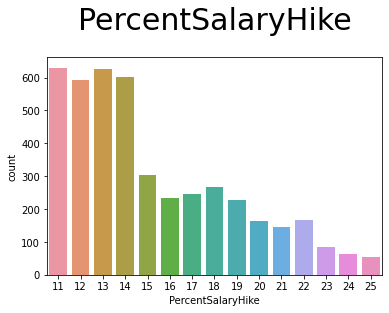

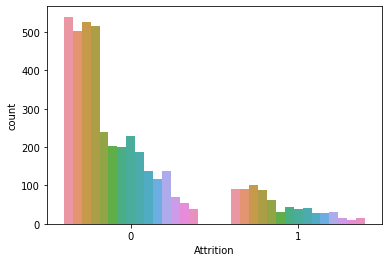

Attrition                 0         1
PercentSalaryHike                    
11                 0.857143  0.142857
12                 0.848485  0.151515
13                 0.837321  0.162679
14                 0.855721  0.144279
15                 0.792079  0.207921
16                 0.871795  0.128205
17                 0.817073  0.182927
18                 0.853933  0.146067
19                 0.815789  0.184211
20                 0.836364  0.163636
21                 0.812500  0.187500
22                 0.821429  0.178571
23                 0.821429  0.178571
24                 0.857143  0.142857
25                 0.722222  0.277778
All                0.838776  0.161224





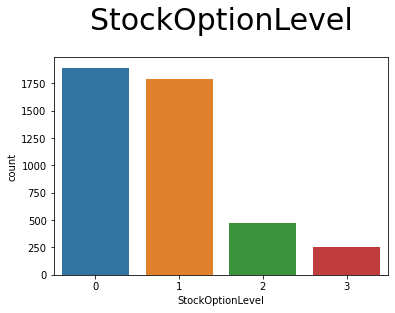

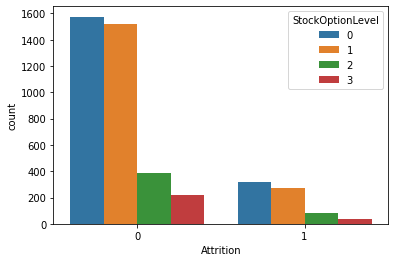

Attrition                0         1
StockOptionLevel                    
0                 0.832013  0.167987
1                 0.848993  0.151007
2                 0.822785  0.177215
3                 0.847059  0.152941
All               0.838776  0.161224





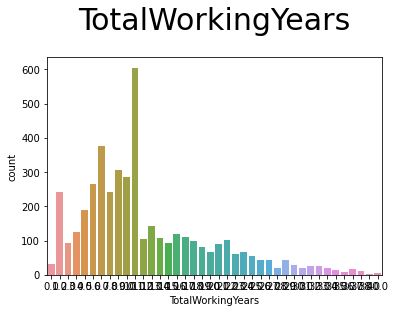

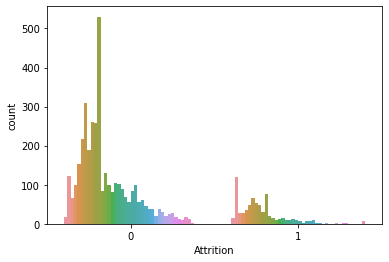

Attrition                 0         1
TotalWorkingYears                    
0.0                0.545455  0.454545
1.0                0.508264  0.491736
2.0                0.709677  0.290323
3.0                0.785714  0.214286
4.0                0.809524  0.190476
5.0                0.818182  0.181818
6.0                0.824000  0.176000
7.0                0.777778  0.222222
8.0                0.846906  0.153094
9.0                0.895470  0.104530
10.0               0.876033  0.123967
11.0               0.801887  0.198113
12.0               0.895833  0.104167
13.0               0.916667  0.083333
14.0               0.870968  0.129032
15.0               0.875000  0.125000
16.0               0.918919  0.081081
17.0               0.909091  0.090909
18.0               0.851852  0.148148
19.0               0.863636  0.136364
20.0               0.932584  0.067416
21.0               0.970588  0.029412
22.0               0.903226  0.096774
23.0               0.909091  0.090909
24.0        

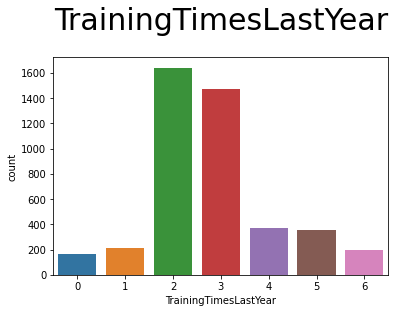

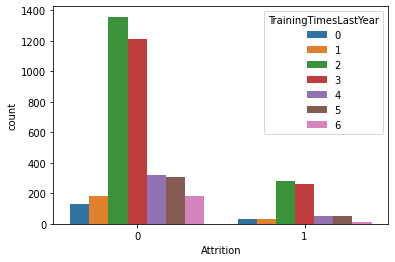

Attrition                     0         1
TrainingTimesLastYear                    
0                      0.814815  0.185185
1                      0.859155  0.140845
2                      0.828154  0.171846
3                      0.824847  0.175153
4                      0.869919  0.130081
5                      0.857143  0.142857
6                      0.938462  0.061538
All                    0.838776  0.161224





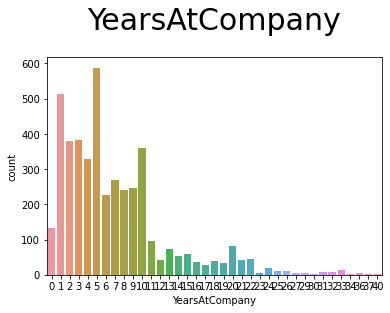

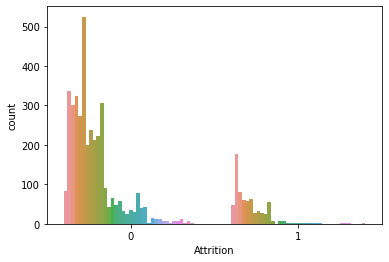

Attrition              0         1
YearsAtCompany                    
0               0.636364  0.363636
1               0.654971  0.345029
2               0.787402  0.212598
3               0.843750  0.156250
4               0.827273  0.172727
5               0.892857  0.107143
6               0.881579  0.118421
7               0.877778  0.122222
8               0.887500  0.112500
9               0.902439  0.097561
10              0.850000  0.150000
11              0.937500  0.062500
12              1.000000  0.000000
13              0.916667  0.083333
14              0.888889  0.111111
15              0.950000  0.050000
16              0.916667  0.083333
17              0.888889  0.111111
18              0.923077  0.076923
19              0.909091  0.090909
20              0.962963  0.037037
21              0.928571  0.071429
22              0.933333  0.066667
23              0.500000  0.500000
24              0.833333  0.166667
25              1.000000  0.000000
26              1.00

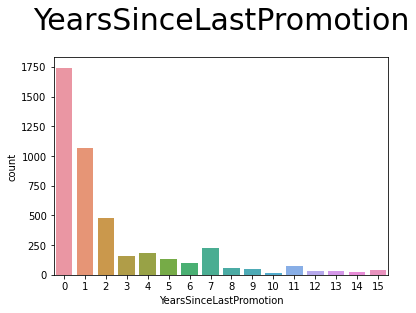

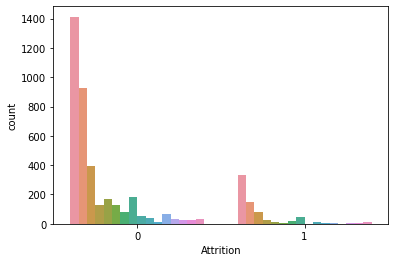

Attrition                       0         1
YearsSinceLastPromotion                    
0                        0.810671  0.189329
1                        0.862745  0.137255
2                        0.830189  0.169811
3                        0.826923  0.173077
4                        0.918033  0.081967
5                        0.955556  0.044444
6                        0.812500  0.187500
7                        0.789474  0.210526
8                        1.000000  0.000000
9                        0.764706  0.235294
10                       0.833333  0.166667
11                       0.916667  0.083333
12                       1.000000  0.000000
13                       0.800000  0.200000
14                       0.888889  0.111111
15                       0.769231  0.230769
All                      0.838776  0.161224





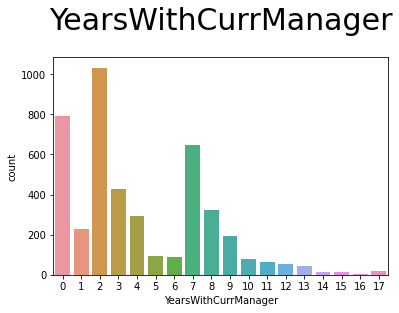

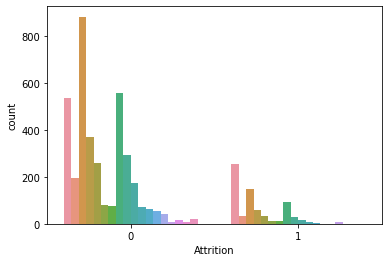

Attrition                    0         1
YearsWithCurrManager                    
0                     0.676806  0.323194
1                     0.855263  0.144737
2                     0.854651  0.145349
3                     0.866197  0.133803
4                     0.887755  0.112245
5                     0.870968  0.129032
6                     0.862069  0.137931
7                     0.856481  0.143519
8                     0.906542  0.093458
9                     0.906250  0.093750
10                    0.888889  0.111111
11                    0.954545  0.045455
12                    1.000000  0.000000
13                    1.000000  0.000000
14                    0.600000  0.400000
15                    1.000000  0.000000
16                    1.000000  0.000000
17                    1.000000  0.000000
All                   0.838776  0.161224





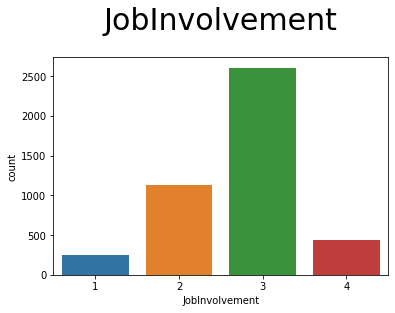

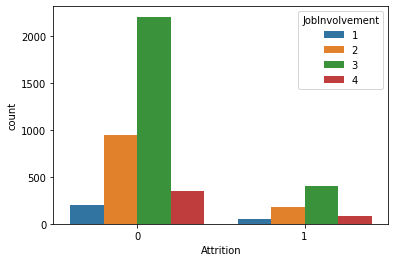

Attrition              0         1
JobInvolvement                    
1               0.783133  0.216867
2               0.840000  0.160000
3               0.846774  0.153226
4               0.819444  0.180556
All             0.838776  0.161224





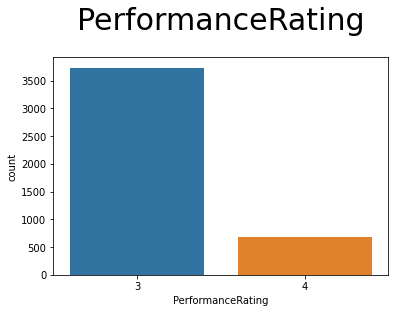

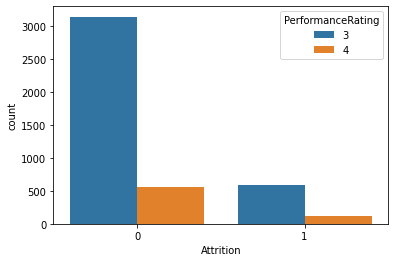

Attrition                 0         1
PerformanceRating                    
3                  0.842444  0.157556
4                  0.818584  0.181416
All                0.838776  0.161224





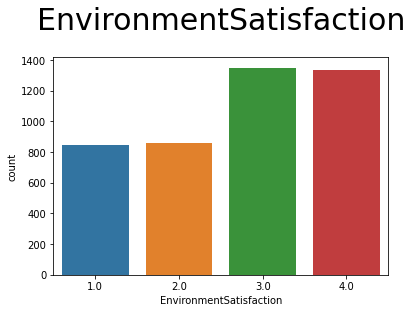

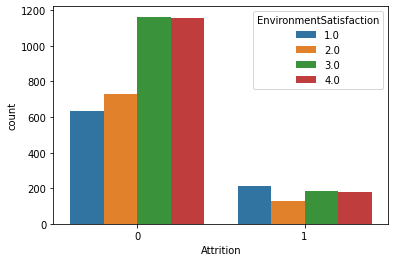

Attrition                       0         1
EnvironmentSatisfaction                    
1.0                      0.747929  0.252071
2.0                      0.850467  0.149533
3.0                      0.862222  0.137778
4.0                      0.865817  0.134183
All                      0.838997  0.161003





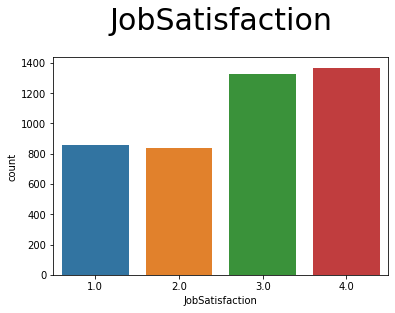

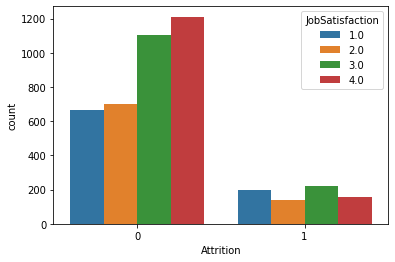

Attrition               0         1
JobSatisfaction                    
1.0              0.770930  0.229070
2.0              0.835714  0.164286
3.0              0.834467  0.165533
4.0              0.885881  0.114119
All              0.838269  0.161731





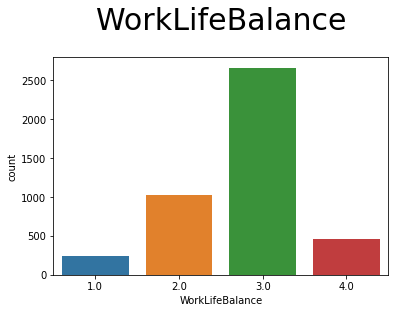

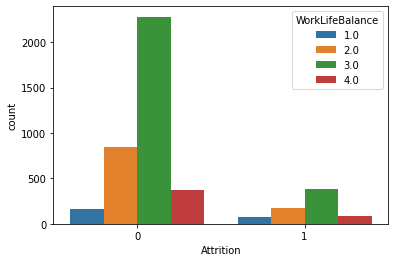

Attrition               0         1
WorkLifeBalance                    
1.0              0.686192  0.313808
2.0              0.832188  0.167812
3.0              0.857143  0.142857
4.0              0.821586  0.178414
All              0.838289  0.161711





In [149]:
for i, column in enumerate(data.columns):
    sns.countplot(x=column, data=data).set_title(column, y=1.1, fontsize=30)
    plt.show()
    g = sns.countplot(x= 'Attrition', data=data, hue=column)
    if data[column].nunique()>10:
        plt.legend([],[], frameon=False)
    plt.show()
    print(pd.crosstab(columns=[data.Attrition], index=[data[column]], margins=True, normalize='index'))
    print('\n\n')

# Exploration des données

### Encoder

In [150]:
categories_attributes = ["Department", "EducationField", "JobRole", 'BusinessTravel']
data_prepared = pd.get_dummies(data, columns=categories_attributes)
data_prepared.head(n=20)

,Attrition,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,0,6,2,1,131160,1.0,11,0,1.0,6,...,0,0,0,0,0,0,0,0,0,1
1,1,10,1,1,41890,0.0,23,1,6.0,3,...,0,0,0,0,1,0,0,0,1,0
2,0,17,4,4,193280,1.0,15,3,5.0,2,...,0,0,0,0,0,1,0,0,1,0
3,0,2,5,3,83210,3.0,11,3,13.0,5,...,0,0,0,0,0,0,0,1,0,0
4,0,10,1,1,23420,4.0,12,2,9.0,2,...,0,0,0,0,0,1,0,0,0,1
5,0,8,3,4,40710,3.0,13,0,28.0,5,...,0,0,0,1,0,0,0,0,0,1
6,1,11,2,2,58130,2.0,20,1,5.0,2,...,0,0,0,0,0,1,0,0,0,1
7,0,18,3,2,31430,2.0,22,3,10.0,2,...,0,0,0,0,0,1,0,0,0,1
8,0,1,3,3,20440,0.0,21,0,10.0,2,...,1,0,0,0,0,0,0,0,0,1
9,0,7,4,4,134640,1.0,13,1,6.0,2,...,1,0,0,0,0,0,0,1,0,0


### Scaler

/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


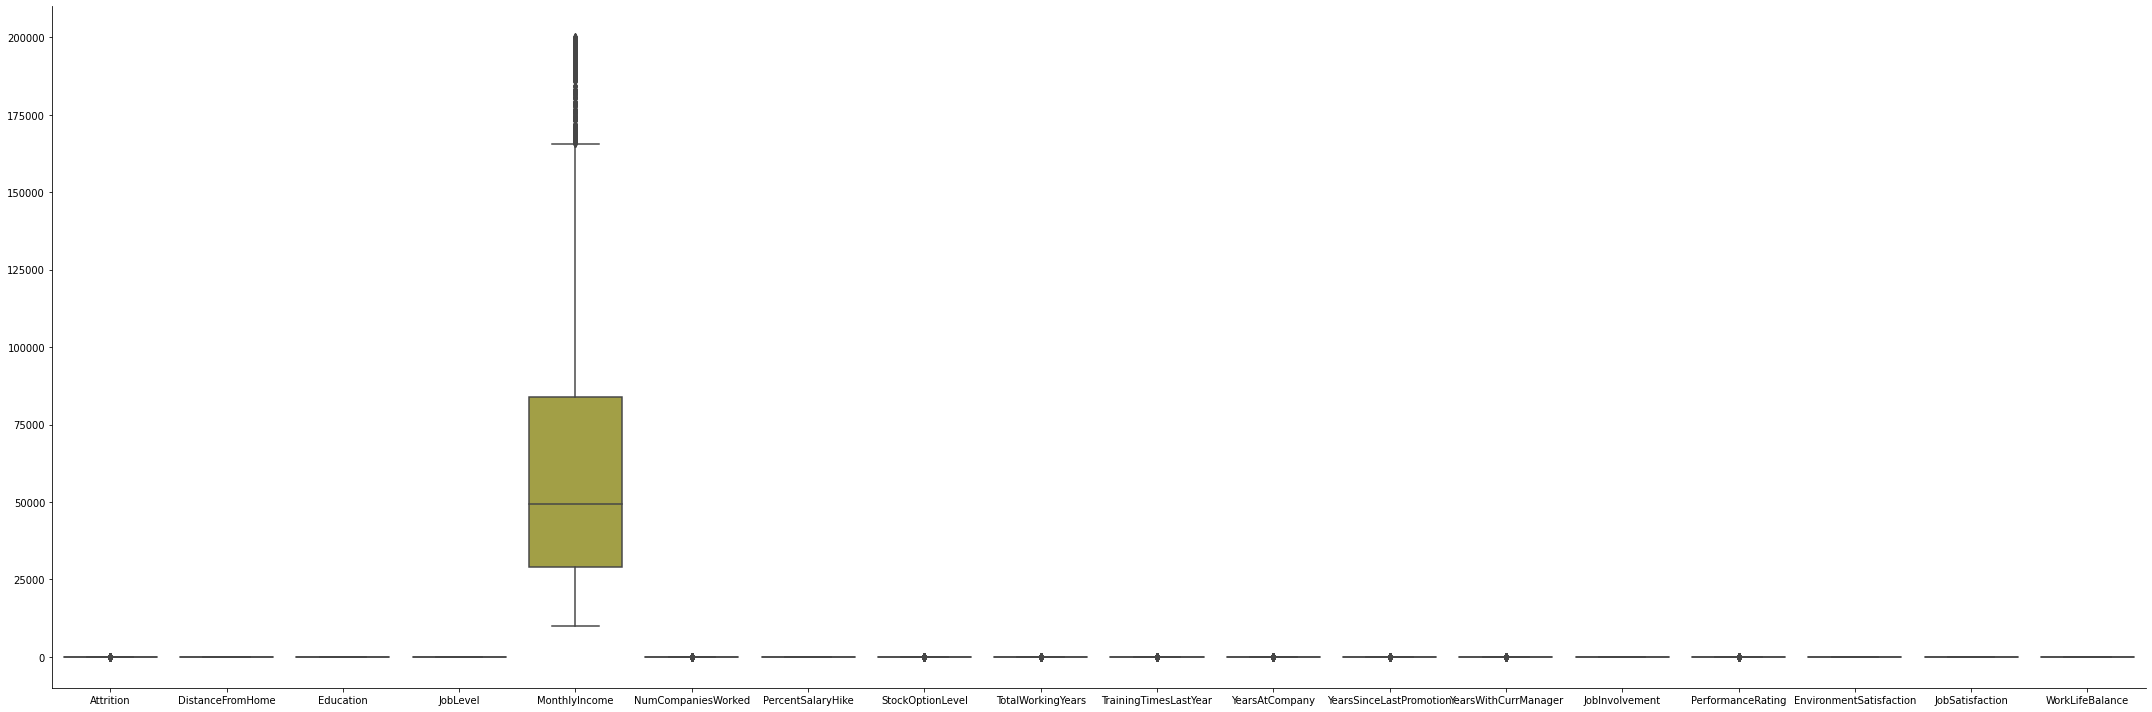

In [151]:
sns.factorplot(data=data, kind='box',size=10,aspect=3)

/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/xlabarbe/.local/lib/python3.10/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


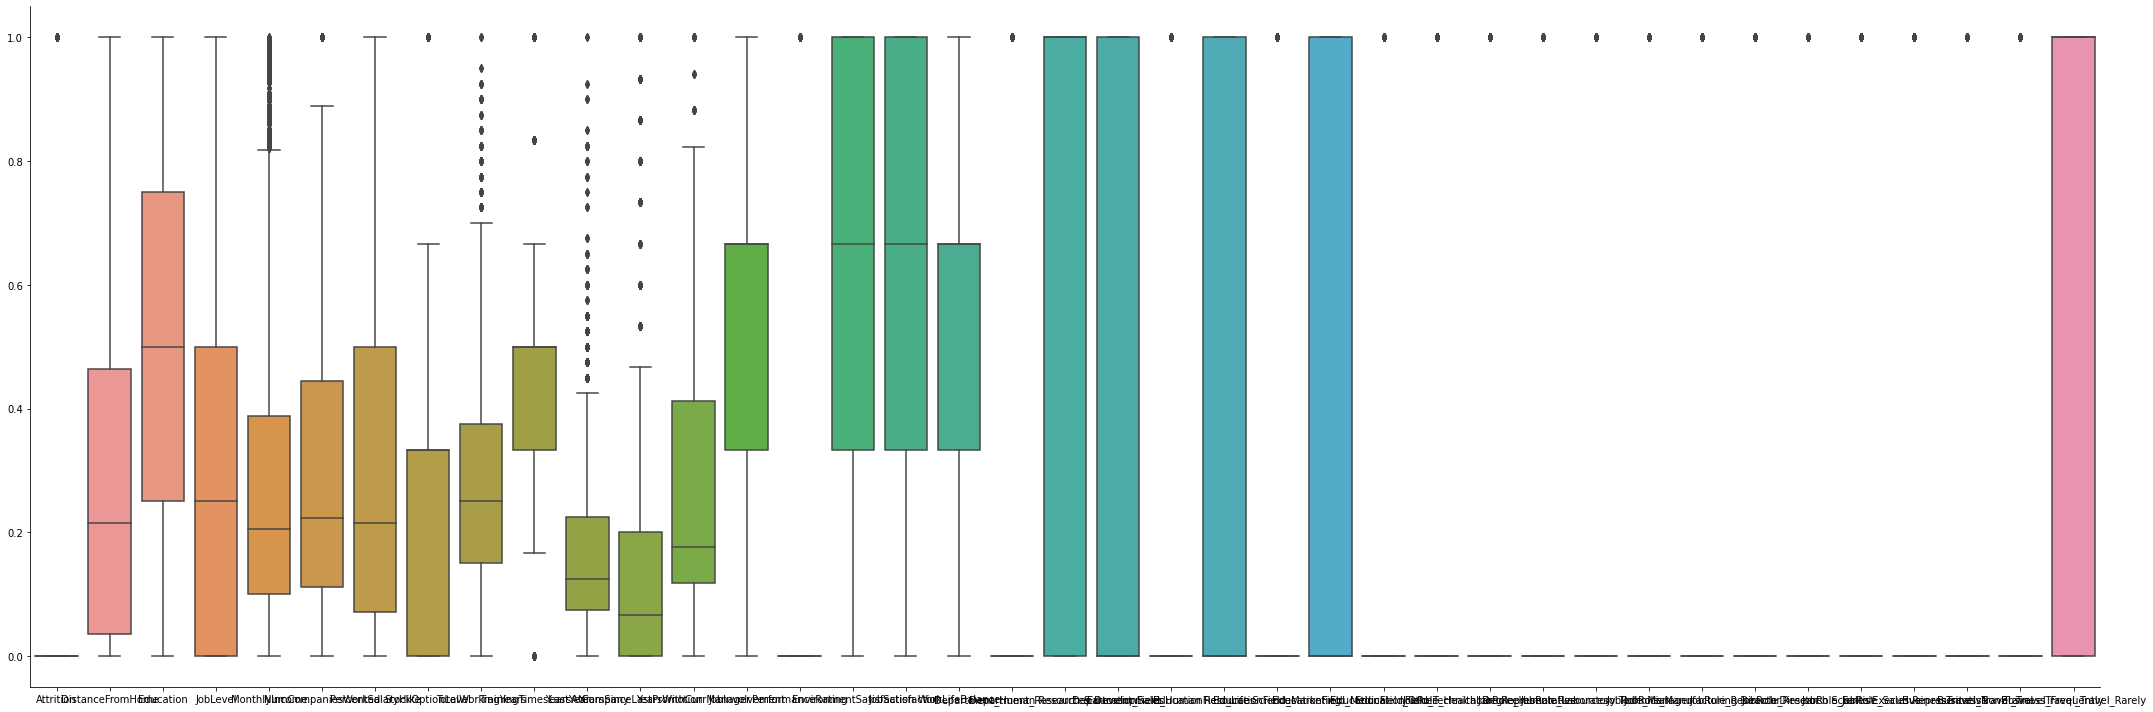

In [158]:
monthly_income_scaled = MinMaxScaler()
data_prepared = pd.DataFrame(monthly_income_scaled.fit_transform(data_prepared), columns = data_prepared.columns)
sns.factorplot(data=data_prepared, kind='box',size=10,aspect=3)

In [160]:
knnImputer = KNNImputer()
data_prepared = pd.DataFrame(knnImputer.fit_transform(data_prepared), columns=data_prepared.columns)
data_prepared.isna().sum()

Attrition                            0
DistanceFromHome                     0
Education                            0
JobLevel                             0
MonthlyIncome                        0
NumCompaniesWorked                   0
PercentSalaryHike                    0
StockOptionLevel                     0
TotalWorkingYears                    0
TrainingTimesLastYear                0
YearsAtCompany                       0
YearsSinceLastPromotion              0
YearsWithCurrManager                 0
JobInvolvement                       0
PerformanceRating                    0
EnvironmentSatisfaction              0
JobSatisfaction                      0
WorkLifeBalance                      0
Department_Human Resources           0
Department_Research & Development    0
Department_Sales                     0
EducationField_Human Resources       0
EducationField_Life Sciences         0
EducationField_Marketing             0
EducationField_Medical               0
EducationField_Other     